# Stage 3 - Entity Matching

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

import py_entitymatching as em

IS_DEVELOPING = True

data_dir = './dataset/structured_data/'
A_filename = 'forbes_sample.csv' if IS_DEVELOPING else 'forbes_all.csv'
B_filename = 'nasdaq_sample.csv' if IS_DEVELOPING else 'nasdaq.csv'
blocked_filename = 'blocked_sample.csv' if IS_DEVELOPING else 'blocked.csv'
labeled_filename = 'labeled_sample.csv' if IS_DEVELOPING else 'labeled.csv'

all_fields = ['Name', 'Industry', 'MarketValue']

# Set the seed value for reproducibility
seed = 0

## Mathcing

In [2]:
A = pd.read_csv(data_dir + A_filename)
A = A[['id'] + all_fields]
em.set_key(A, 'id')
B = pd.read_csv(data_dir + B_filename)
B = B[['id'] + all_fields]
em.set_key(B, 'id')
# Load the pre-labeled data
S = em.read_csv_metadata(data_dir + labeled_filename, 
                         key='_id',
                         ltable=A, rtable=B, 
                         fk_ltable='ltable_id', fk_rtable='rtable_id')

Metadata file is not present in the given path; proceeding to read the csv file.


Then, split the labeled data into development set and evaluation set. Use the development set to select the best learning-based matcher.

In [3]:
# Split S into I an J
IJ = em.split_train_test(S, train_proportion=0.5, random_state=seed)
I = IJ['train']
J = IJ['test']

### Creating features

In [4]:
# Generate a set of features
F = em.get_features_for_matching(A, B)

In [5]:
F.feature_name

0                                   id_id_exm
1                                   id_id_anm
2                              id_id_lev_dist
3                               id_id_lev_sim
4                   Name_Name_jac_qgm_3_qgm_3
5               Name_Name_cos_dlm_dc0_dlm_dc0
6               Name_Name_jac_dlm_dc0_dlm_dc0
7                               Name_Name_mel
8                          Name_Name_lev_dist
9                           Name_Name_lev_sim
10                              Name_Name_nmw
11                               Name_Name_sw
12          Industry_Industry_jac_qgm_3_qgm_3
13      Industry_Industry_cos_dlm_dc0_dlm_dc0
14      Industry_Industry_jac_dlm_dc0_dlm_dc0
15                      Industry_Industry_mel
16                 Industry_Industry_lev_dist
17                  Industry_Industry_lev_sim
18                      Industry_Industry_nmw
19                       Industry_Industry_sw
20           MarketValue_MarketValue_lev_dist
21            MarketValue_MarketVa

### Extracting feature vectors

In [6]:
# Convert the I into a set of feature vectors using F
H = em.extract_feature_vecs(I, 
                            feature_table=F, 
                            attrs_after='is_match',
                            show_progress=False)  
# Display first few rows
H.head()

,_id,ltable_id,rtable_id,id_id_exm,id_id_anm,id_id_lev_dist,id_id_lev_sim,Name_Name_jac_qgm_3_qgm_3,Name_Name_cos_dlm_dc0_dlm_dc0,Name_Name_jac_dlm_dc0_dlm_dc0,...,Industry_Industry_lev_sim,Industry_Industry_nmw,Industry_Industry_sw,MarketValue_MarketValue_lev_dist,MarketValue_MarketValue_lev_sim,MarketValue_MarketValue_jar,MarketValue_MarketValue_jwn,MarketValue_MarketValue_exm,MarketValue_MarketValue_jac_qgm_3_qgm_3,is_match
16,16,32,77,0,0.415584,2,0.000000,0.105263,0.223607,0.125000,...,0.055556,-14.0,1.0,4,0.200000,0.483333,0.483333,0,0.000000,1
54,54,95,193,0,0.492228,2,0.333333,0.696970,0.408248,0.250000,...,0.190476,-9.0,2.0,7,0.000000,0.000000,0.000000,0,0.000000,1
20,20,32,79,0,0.405063,2,0.000000,0.705882,0.670820,0.500000,...,0.181818,0.0,9.0,5,0.375000,0.708333,0.708333,0,0.066667,1
48,48,86,174,0,0.494253,3,0.000000,0.615385,0.577350,0.400000,...,0.206897,-16.0,4.0,7,0.000000,0.000000,0.000000,0,0.000000,0
8,8,18,38,0,0.473684,1,0.500000,0.153846,0.258199,0.142857,...,0.153846,-8.0,1.0,6,0.142857,0.464286,0.464286,0,0.000000,0


In [7]:
# Check if the feature vectors contain missing values
# A return value of True means that there are missing values
any(pd.notnull(H))

True

We observe that the extracted feature vectors contain missing values. We have to impute the missing values for the learning-based matchers to fit the model correctly.

In [8]:
# Impute feature vectors with the mean of the column values.
H_imputed = em.impute_table(H, 
                exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'is_match'],
                strategy='mean')

### Selecting the best matcher using cross-validation

First, we need to create a set of learning-based matchers. The following matchers are supported in Magellan: (1) decision tree, (2) random forest, (3) naive bayes, (4) svm, (5) logistic regression, and (6) linear regression.

In [26]:
# Create a set of ML-matchers
dt = em.DTMatcher(name='DecisionTree', random_state=seed)
svm = em.SVMMatcher(name='SVM', random_state=seed)
rf = em.RFMatcher(name='RF', random_state=seed)
lg = em.LogRegMatcher(name='LogReg', random_state=seed)
ln = em.LinRegMatcher(name='LinReg')

Now, we select the best matcher using k-fold cross-validation. Here we use 5-fold cross validation and use precision, recall, and F-1 metric to select the best matcher.

In [10]:
# Performing CV using precision
result = em.select_matcher([dt, rf, svm, ln, lg], table=H_imputed, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'is_match'],
        k=5,
        target_attr='is_match', metric='precision', random_state=seed)
result['cv_stats']

,Name,Matcher,Num folds,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean score
0,DecisionTree,<py_entitymatching.matcher.dtmatcher.DTMatcher object at 0x10dcdaac8>,5,1.000000,0.800000,0.666667,1.00,0.500000,0.793333
1,RF,<py_entitymatching.matcher.rfmatcher.RFMatcher object at 0x10dcdab38>,5,1.000000,1.000000,0.750000,1.00,0.333333,0.816667
2,SVM,<py_entitymatching.matcher.svmmatcher.SVMMatcher object at 0x10dcdae10>,5,0.833333,0.833333,0.600000,0.60,0.500000,0.673333
3,LinReg,<py_entitymatching.matcher.linregmatcher.LinRegMatcher object at 0x10dcda908>,5,1.000000,1.000000,1.000000,0.50,0.666667,0.833333
4,LogReg,<py_entitymatching.matcher.logregmatcher.LogRegMatcher object at 0x10dcdaa90>,5,1.000000,1.000000,1.000000,0.75,0.500000,0.850000


In [11]:
# Performing CV using recall
result = em.select_matcher([dt, rf, svm, ln, lg], table=H_imputed, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'is_match'],
        k=5,
        target_attr='is_match', metric='recall', random_state=seed)
result['cv_stats']

,Name,Matcher,Num folds,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean score
0,DecisionTree,<py_entitymatching.matcher.dtmatcher.DTMatcher object at 0x10dcdaac8>,5,0.8,0.8,0.666667,0.666667,0.5,0.686667
1,RF,<py_entitymatching.matcher.rfmatcher.RFMatcher object at 0x10dcdab38>,5,0.8,0.4,1.000000,0.666667,0.5,0.673333
2,SVM,<py_entitymatching.matcher.svmmatcher.SVMMatcher object at 0x10dcdae10>,5,1.0,1.0,1.000000,1.000000,1.0,1.000000
3,LinReg,<py_entitymatching.matcher.linregmatcher.LinRegMatcher object at 0x10dcda908>,5,0.6,0.6,0.333333,0.666667,1.0,0.640000
4,LogReg,<py_entitymatching.matcher.logregmatcher.LogRegMatcher object at 0x10dcdaa90>,5,1.0,0.6,1.000000,1.000000,0.5,0.820000


In [12]:
# Performing CV using F-1
result = em.select_matcher([dt, rf, svm, ln, lg], table=H_imputed, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'is_match'],
        k=5,
        target_attr='is_match', metric='f1', random_state=seed)
result['cv_stats']

,Name,Matcher,Num folds,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean score
0,DecisionTree,<py_entitymatching.matcher.dtmatcher.DTMatcher object at 0x10dcdaac8>,5,0.888889,0.800000,0.666667,0.800000,0.500000,0.731111
1,RF,<py_entitymatching.matcher.rfmatcher.RFMatcher object at 0x10dcdab38>,5,0.888889,0.571429,0.857143,0.800000,0.400000,0.703492
2,SVM,<py_entitymatching.matcher.svmmatcher.SVMMatcher object at 0x10dcdae10>,5,0.909091,0.909091,0.750000,0.750000,0.666667,0.796970
3,LinReg,<py_entitymatching.matcher.linregmatcher.LinRegMatcher object at 0x10dcda908>,5,0.750000,0.750000,0.500000,0.571429,0.800000,0.674286
4,LogReg,<py_entitymatching.matcher.logregmatcher.LogRegMatcher object at 0x10dcdaa90>,5,1.000000,0.750000,1.000000,0.857143,0.500000,0.821429


We select SVM matcher for its highest reall and F-1.

### Debug X (SVM)

Split the feature vectors H of the development set I into a training set P and a testing set Q.

In [13]:
# Split H into P and Q
PQ = em.split_train_test(H, train_proportion=0.5, random_state=seed)
P = PQ['train']
Q = PQ['test']

Since there is no visual debugger for SVM matcher, we debug SVM matcher using proxy debugging with Decision Tree matcher.

In [16]:
# Debug Decision Tree matcher using GUI
em.vis_debug_dt(dt, P, Q, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'is_match'],
        target_attr='is_match')

TODO: Refer to <a href="https://nbviewer.jupyter.org/github/anhaidgroup/py_entitymatching/blob/rel_0.1.x/notebooks/guides/step_wise_em_guides/Selecting%20the%20Best%20Learning%20Matcher.ipynb#Debug-X-(Random-Forest)">this guide</a> to know more about visual debugging.

TODO: We found xxx problems and yyy to fix them.

In [17]:
# Add some new feature to F

In [19]:
# Convert I into feature vectors using updated F
H = em.extract_feature_vecs(I, 
                            feature_table=F, 
                            attrs_after='is_match',
                            show_progress=False)

In [20]:
# Check whether the updated F improves X 
result = em.select_matcher([svm], table=H, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'is_match'],
        k=5,
        target_attr='is_match', metric='f1', random_state=0)
result['cv_stats']

,Name,Matcher,Num folds,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean score
0,SVM,<py_entitymatching.matcher.svmmatcher.SVMMatcher object at 0x10dcdae10>,5,0.909091,0.909091,0.75,0.75,0.666667,0.79697


### Selecting the best matcher using cross-validation

### Debug X

### Selecting the best matcher using cross-validation

### Testing

In [21]:
# Instantiate matchers to evaluate.
matchers = [
    em.DTMatcher(name='DecisionTree', random_state=seed),
    em.SVMMatcher(name='SVM', random_state=seed),
    em.RFMatcher(name='RF', random_state=seed),
    em.LogRegMatcher(name='LogReg', random_state=seed),
    em.LinRegMatcher(name='LinReg'),
]

In [27]:
eval_results = []
for m in matchers :
    # Train using feature vectors from I 
    m.fit(table=H, 
           exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'is_match'], 
           target_attr='is_match')

    # Convert J into a set of feature vectors using F
    L = em.extract_feature_vecs(J, feature_table=F,
                                attrs_after='is_match', show_progress=False)

    # Predict on L 
    predictions = dt.predict(table=L, exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'is_match'], 
                  append=True, target_attr='predicted', inplace=False)
    # Evaluate the predictions
    eval_result = em.eval_matches(predictions, 'is_match', 'predicted')
    eval_results.append(eval_result)
    em.print_eval_summary(eval_result)

Precision : 95.65% (22/23)
Recall : 88.0% (22/25)
F1 : 91.67%
False positives : 1 (out of 23 positive predictions)
False negatives : 3 (out of 5 negative predictions)
Precision : 95.65% (22/23)
Recall : 88.0% (22/25)
F1 : 91.67%
False positives : 1 (out of 23 positive predictions)
False negatives : 3 (out of 5 negative predictions)
Precision : 95.65% (22/23)
Recall : 88.0% (22/25)
F1 : 91.67%
False positives : 1 (out of 23 positive predictions)
False negatives : 3 (out of 5 negative predictions)
Precision : 95.65% (22/23)
Recall : 88.0% (22/25)
F1 : 91.67%
False positives : 1 (out of 23 positive predictions)
False negatives : 3 (out of 5 negative predictions)
Precision : 95.65% (22/23)
Recall : 88.0% (22/25)
F1 : 91.67%
False positives : 1 (out of 23 positive predictions)
False negatives : 3 (out of 5 negative predictions)


In [35]:
df = pd.DataFrame(eval_results, index=[m.name for m in matchers])

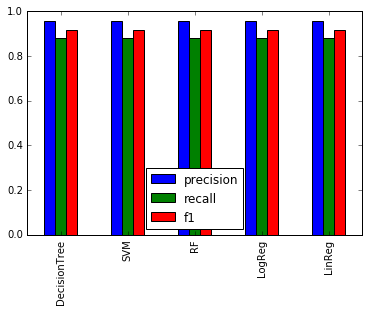

In [36]:
df[['precision', 'recall', 'f1']].plot(kind='bar')